In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 

from helpers.composite_helpers import *


In [2]:
curtains_dir = "/global/home/users/rrmastandrea/CURTAINS_SALAD/"

n_features = 5
dataset_config_string = f"LHCO_minmax_new/"

exp_dir = os.path.join(curtains_dir, dataset_config_string)

bands_dict = {"ob1": [3000, 3200],
                  "sb1": [3200, 3400],
                  "sr" : [3400, 3600],
                  "sb2": [3600, 3800],
                  "ob2": [3800, 4000]}

binning_scheme = np.linspace(-3.5, 3.5, 40)
bin_centers = 0.5*(binning_scheme[1:] + binning_scheme[:-1])

    


In [3]:
# BD
num_layers_BD = 8
num_hidden_features_BD = 64
hyperparameters_dict_BD = {"n_epochs": 100,
                          "batch_size": 128,
                          "lr": 0.0001,
                          "weight_decay": 0.0001}

loc_id_BD = f"Masked_PRQ_AR_{num_layers_BD}layers_{num_hidden_features_BD}hidden_LRCos" # to distingush the saved models


BD_dir = os.path.join(exp_dir, f"saved_models_{loc_id_BD}/")
BD_samples_dir = os.path.join(BD_dir, f"npy_samples/")

# s2d

num_layers_s2d = 2
num_blocks_s2d = 8
num_nodes_s2d = 32
loc_id_s2d = f"PRQ_Coupling_{num_layers_s2d}layers_{num_blocks_s2d}blocks_{num_nodes_s2d}nodes_LRCos" # to distingush the saved models

hyperparameters_dict_s2d = {"n_epochs": 50,
                          "batch_size": 128,
                          "lr": 0.0001,
                          "weight_decay": 0.0001}



s2d_dir = os.path.join(BD_dir, f"saved_models_{loc_id_s2d}/")
samples_dir = os.path.join(s2d_dir, f"npy_samples/")



In [4]:
# Load in npy samples
sim_samples = {}
transformed_sim_samples = {}
dat_samples = {}



for band in list(bands_dict.keys()):
    # sim
    sim_samples[band] = np.load(os.path.join(samples_dir, f"{band}_SIM.npy"))
    # trans sim
    transformed_sim_samples[band] = np.load(os.path.join(samples_dir, f"{band}_transSIM.npy"))
    # dat
    dat_samples[band] = np.load(os.path.join(samples_dir, f"{band}_DAT.npy"))
                
# BD
SB_BD_samples = np.load(os.path.join(samples_dir, f"BD.npy"))

# transBD
SB_trans_BD_samples = np.load(os.path.join(samples_dir, f"transBD.npy"))

# dat_sideband
SB_dat_samples = np.load(os.path.join(samples_dir, f"DAT_SB.npy"))

# Test CURTAINS-SALAD performance

Plot ratio (DATA/SIM) in SR

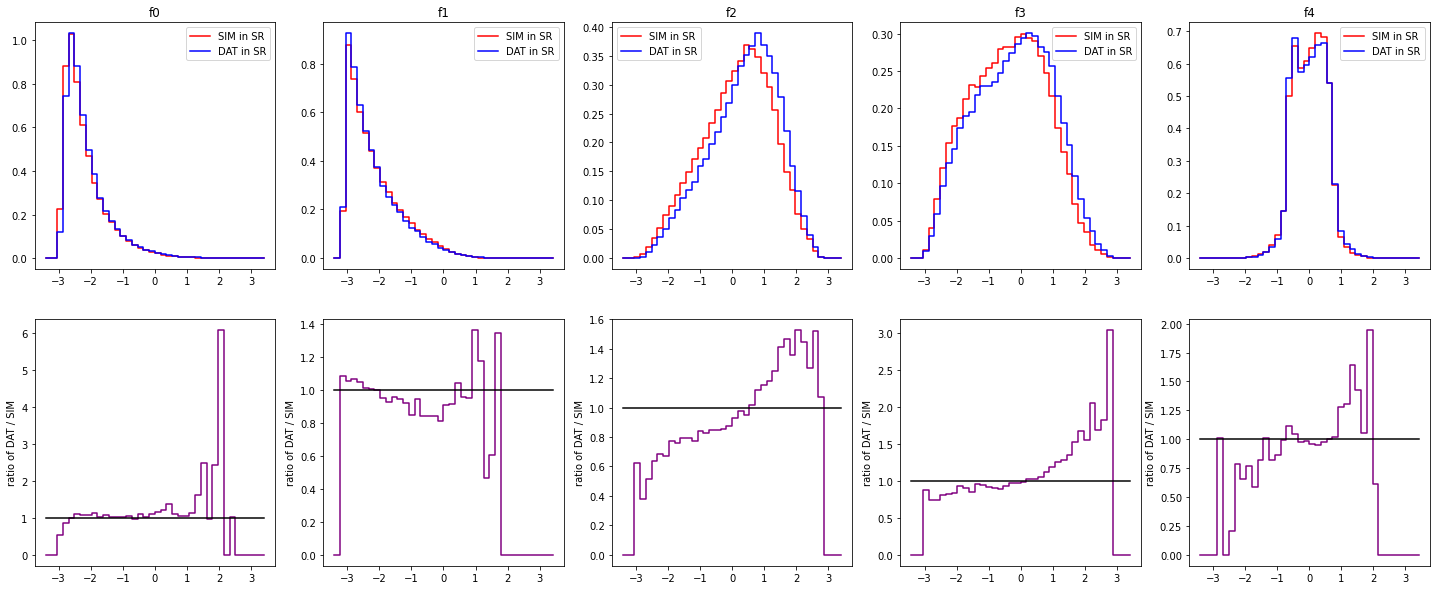

In [5]:


alpha = 0.5
n_features = sim_samples["sr"].shape[-1]
   
fig, ax = plt.subplots(2, n_features, figsize = (5*n_features, 2*5))
for i in range(n_features):
    
    dat_SR_hist, _ = np.histogram(dat_samples["sr"][:,i], bins = binning_scheme, density = True)
    sim_SR_hist, _ = np.histogram(sim_samples["sr"][:,i], bins = binning_scheme, density = True)

    ratio_hist = np.divide(dat_SR_hist, sim_SR_hist, out=np.zeros_like(dat_SR_hist), where=sim_SR_hist!=0)

    # Plots hists
    ax[0, i].step(bin_centers, sim_SR_hist, label = "SIM in SR", color = "red")
    ax[0, i].step(bin_centers, dat_SR_hist, label = "DAT in SR", color = "blue") 
    ax[0, i].legend()
    ax[0, i].set_title(f"f{i}")

    # Plot ratios
    ax[1, i].step(bin_centers, ratio_hist, color = "purple") 
    ax[1, i].plot(bin_centers, np.ones(bin_centers.shape), color = "black") 
    ax[1, i].set_ylabel("ratio of DAT / SIM")

    

# Test CURTAINS-SALAD performance

Plot ratio (trans SIM in SR)/(trans SIM in SB)

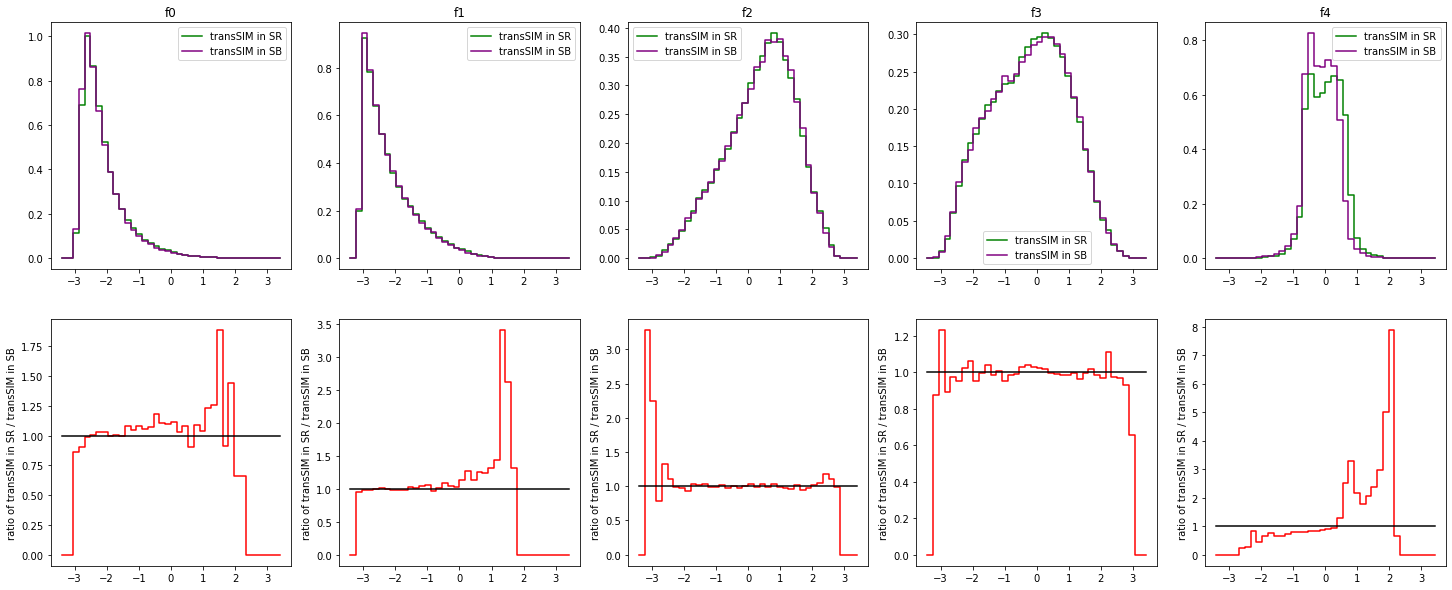

In [6]:
alpha = 0.5
n_features = sim_samples["sr"].shape[-1]
   
fig, ax = plt.subplots(2, n_features, figsize = (5*n_features, 2*5))
for i in range(n_features):
    
    transSIM_SR_hist, _ = np.histogram(transformed_sim_samples["sr"][:,i], bins = binning_scheme, density = True)
    
    sb1 = transformed_sim_samples["sb1"][:,i]
    sb2 = transformed_sim_samples["sb1"][:,i]
    sb = np.concatenate((sb1, sb2))
    transSIM_SB_hist, _ = np.histogram(sb, bins = binning_scheme, density = True)

    ratio_hist = np.divide(transSIM_SR_hist, transSIM_SB_hist, out=np.zeros_like(transSIM_SR_hist), where=transSIM_SB_hist!=0)

    # Plots hists
    ax[0, i].step(bin_centers, transSIM_SR_hist, label = "transSIM in SR", color = "green")
    ax[0, i].step(bin_centers, transSIM_SB_hist, label = "transSIM in SB", color = "purple") 
    ax[0, i].legend()
    ax[0, i].set_title(f"f{i}")

    # Plot ratios
    ax[1, i].step(bin_centers, ratio_hist, color = "red") 
    ax[1, i].plot(bin_centers, np.ones(bin_centers.shape), color = "black") 
    ax[1, i].set_ylabel("ratio of transSIM in SR / transSIM in SB")

